# Quality Control
This notebook calculates some key metrics and generates plots of them to assess the quality of the ATAC-seq and RNA-seq data sets.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

DATA_DIR = "data/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
MMC1_PATH = os.path.join(DATA_DIR, "mmc1.xlsx")

#Load the ATAC-seq data
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])

#Load the RNA-seq data
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)

#Load the meta data
meta1 = pd.read_excel(MMC1_PATH, sheet_name="SortedPopulations")
meta1 = meta1.set_index("SampleName").groupby("CellType")
meta2 = pd.read_excel(MMC1_PATH, sheet_name="Read Statistics")
meta2 = meta2.set_index("sample.name").groupby("population.name")

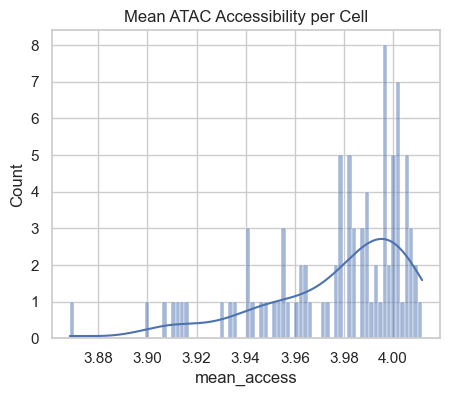

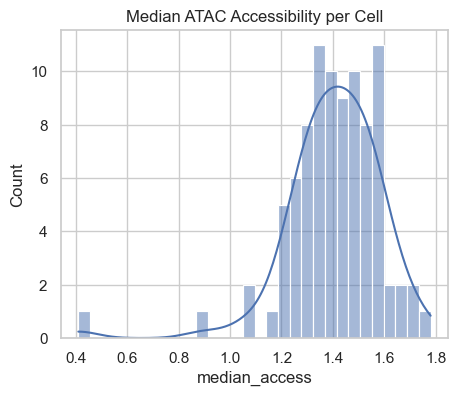

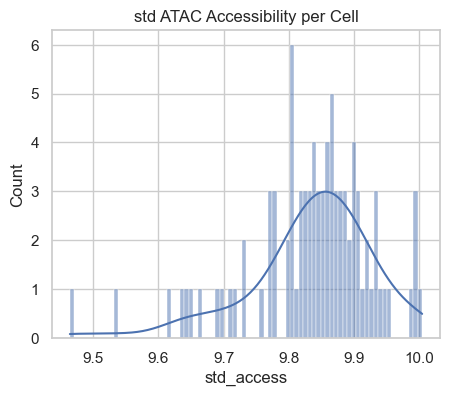

In [32]:
#remove data that aren't cell populations
atac = atac.drop(columns=["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"])
# 1. Compute per‐cell stats
cell_stats = pd.DataFrame({
    "mean_access":   atac.mean(axis=0, numeric_only=True),
    "median_access": atac.median(axis=0, numeric_only=True),
    "std_access":    atac.std(axis=0, numeric_only=True)
})

# 2. Visualize
sns.set_theme(style="whitegrid")

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["mean_access"], bins=80, kde=True)
plt.title("Mean ATAC Accessibility per Cell")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["median_access"], bins=30, kde=True)
plt.title("Median ATAC Accessibility per Cell")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["std_access"], bins=80, kde=True)
plt.title("std ATAC Accessibility per Cell")
plt.show()

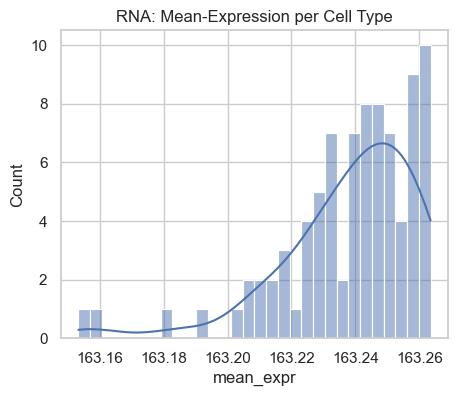

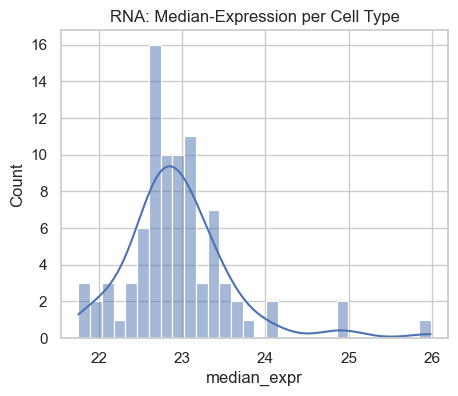

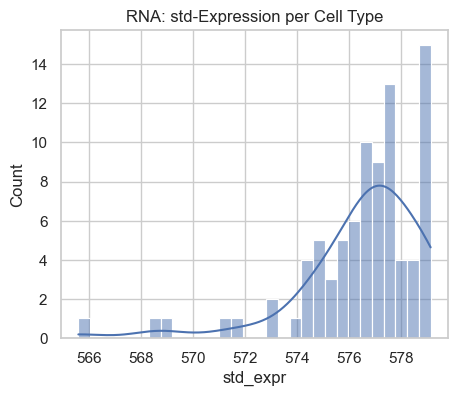

In [33]:
rna_cell_stats = pd.DataFrame({
    "mean_expr":   rna.mean(axis=0),
    "median_expr": rna.median(axis=0),
    "std_expr":    rna.std(axis=0)
})
# Merge QC if desired (e.g. InputCellNumber)
#if "PF.reads" in meta1.columns:
#    rna_cell_stats["PF.reads"] = meta1.groupby("CellType")["PF.reads"].sum()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["mean_expr"], bins=30, kde=True)
plt.title("RNA: Mean-Expression per Cell Type")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["median_expr"], bins=30, kde=True)
plt.title("RNA: Median-Expression per Cell Type")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["std_expr"], bins=30, kde=True)
plt.title("RNA: std-Expression per Cell Type")
plt.show()

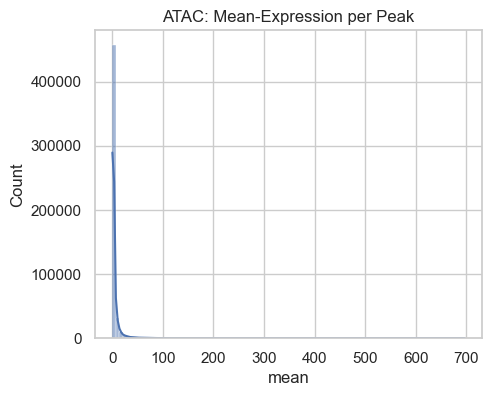

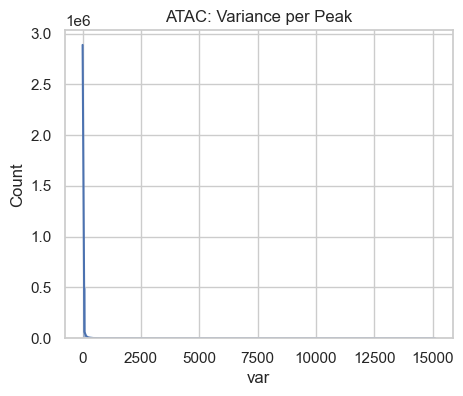

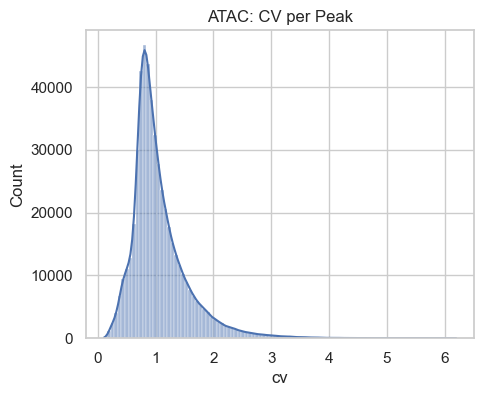

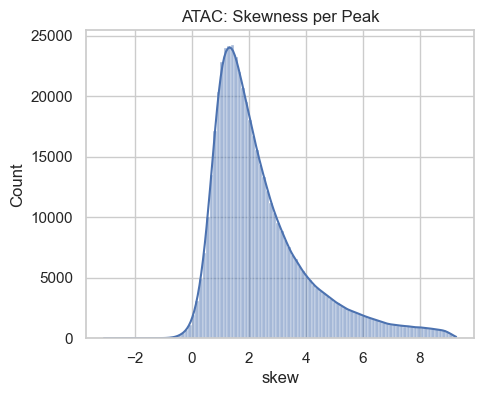

In [34]:
from scipy.stats import skew

# 4.1 Peak stats
peak_stats = pd.DataFrame({
    "mean": atac.mean(axis=1, numeric_only=True),
    "var":  atac.var(axis=1, numeric_only=True),
    "cv":   atac.std(axis=1, numeric_only=True)/(atac.mean(axis=1, numeric_only=True)+1e-6),
    "skew": atac.select_dtypes(include=[np.number]).apply(lambda row: skew(row), axis=1),
    "peak_range": atac.max(axis=1, numeric_only=True) - atac.min(axis=1, numeric_only=True)
})

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["mean"], bins=100, kde=True)
plt.title("ATAC: Mean-Expression per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["var"], bins=100, kde=True)
plt.title("ATAC: Variance per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["cv"], bins=100, kde=True)
plt.title("ATAC: CV per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["skew"], bins=100, kde=True)
plt.title("ATAC: Skewness per Peak")
plt.show()

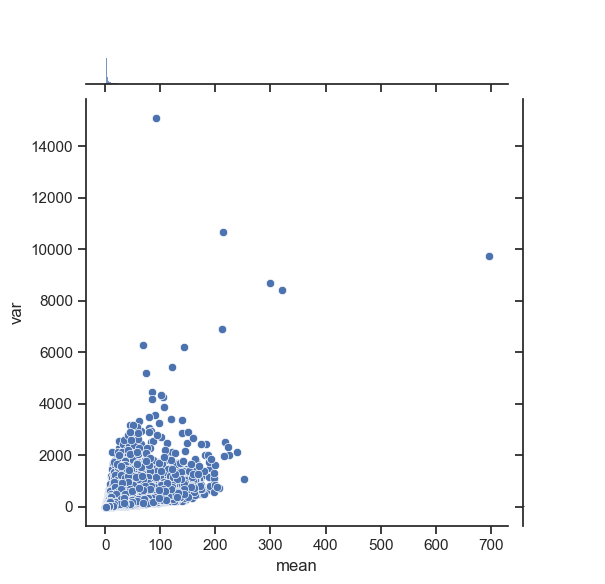

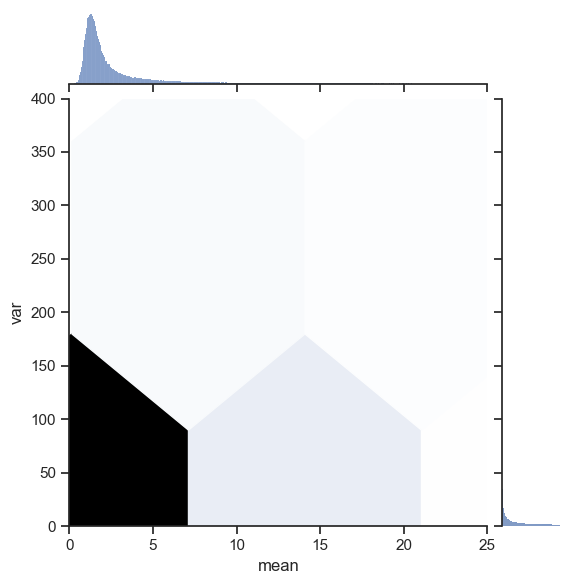

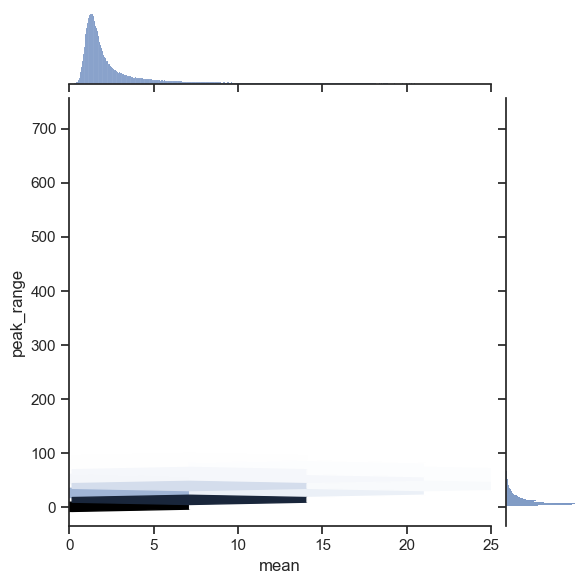

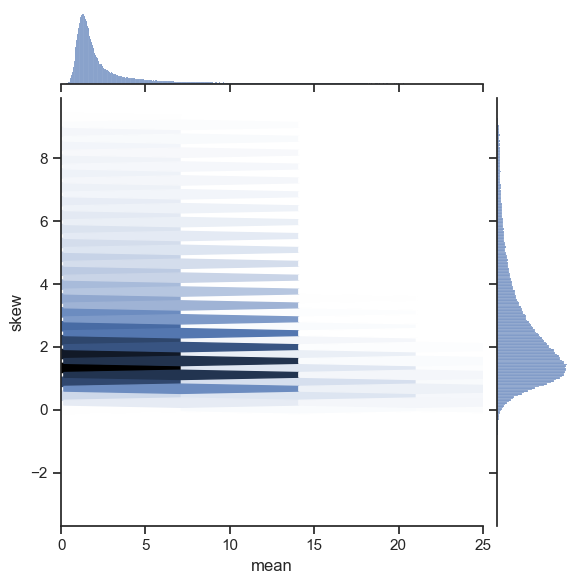

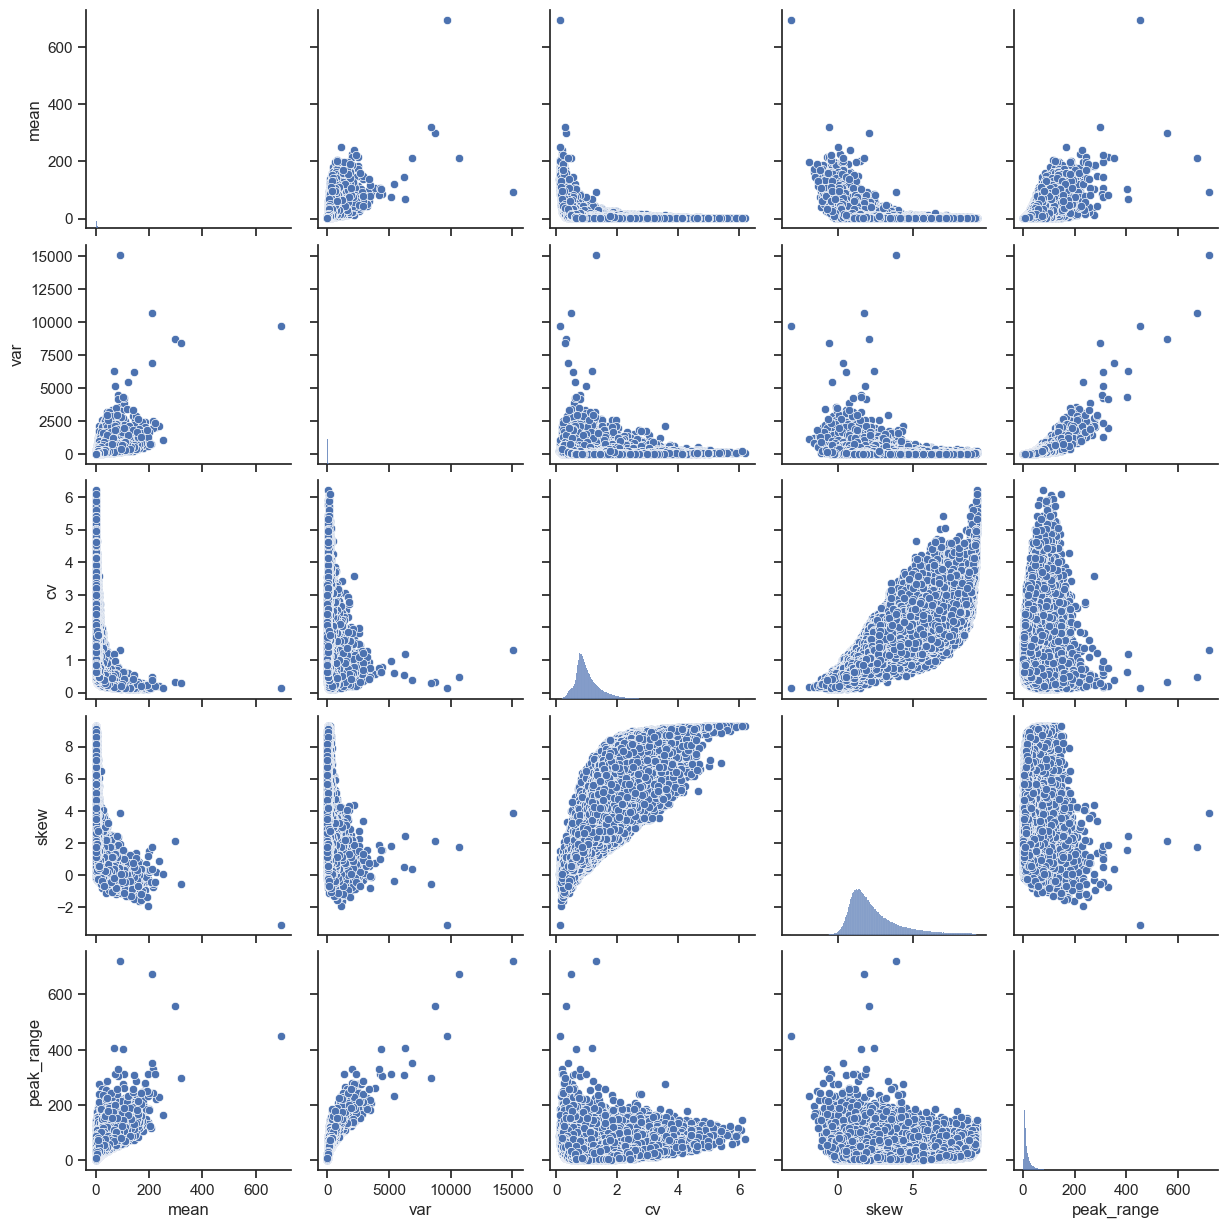

In [40]:
sns.set_theme(style="ticks")

sns.jointplot(
    x="mean", y="var",
    data=peak_stats
)
#plt.title("Hexbin plot for ATAC: Mean vs Variance per Peak")
plt.show()

sns.jointplot(
    x="mean", y="var",
    data=peak_stats,
    kind="hex",
    #color="#4CB391",
    xlim= (0, 25),
    ylim= (0, 400),
    #marginal_kws=dict(bins=50)
)
#plt.title("Hexbin plot for ATAC: Mean vs Variance per Peak")
plt.show()

sns.jointplot(
    x="mean", y="peak_range",
    data=peak_stats,
    kind="hex",
    xlim= (0, 25)
)
plt.show()

sns.jointplot(
    x="mean", y="skew",
    data=peak_stats,
    kind="hex",
    xlim= (0, 25)
)
plt.show()

sns.pairplot(peak_stats)
plt.show()

i. a. Is the signal (median, mean, std) dependent on the sequencing depth, number of input cells, or another QC metric?

In [36]:
meta_sum = meta1.sum().drop(columns=["%chrM.mapped", "%fragment.1Kb_TSS", "Replicate.cor"]).join(meta2.sum().drop(columns=["overal_ alignment_rate%"]))
meta_mean = meta1[["%chrM.mapped", "%fragment.1Kb_TSS", "Replicate.cor"]].mean().join(meta2["overal_ alignment_rate%"].mean())
meta = pd.concat([meta_sum, meta_mean], axis=1)
#meta = meta.drop(columns=["%chrM.mapped", "%fragment.1Kb_TSS", "overal_ alignment_rate%", "Replicate.cor"]) #TODO: proper calculation
meta_num = meta.select_dtypes([np.number])


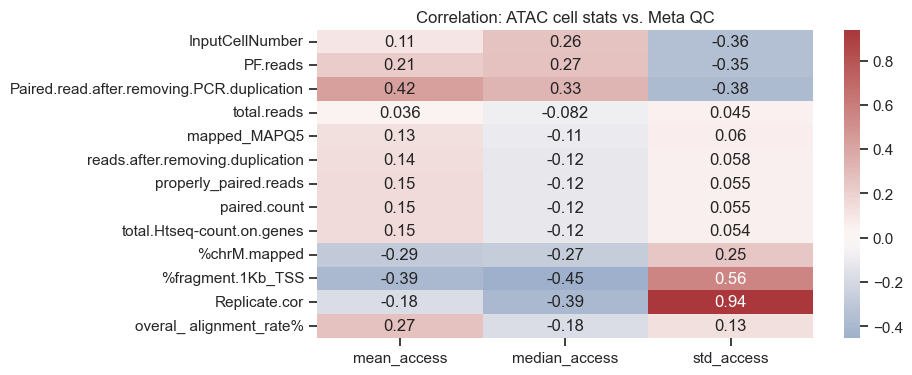

In [37]:
atac_correlation = pd.DataFrame(columns=cell_stats.columns, index=meta_num.columns)
for col in cell_stats.columns:
    for key in meta_num.columns:
        atac_correlation.loc[key, col] = cell_stats[col].corr(meta[key], method='pearson') 

plt.figure(figsize=(8, 4))
sns.heatmap(atac_correlation.astype(float), annot=True, cmap="vlag", center=0)
plt.title("Correlation: ATAC cell stats vs. Meta QC")
plt.show()

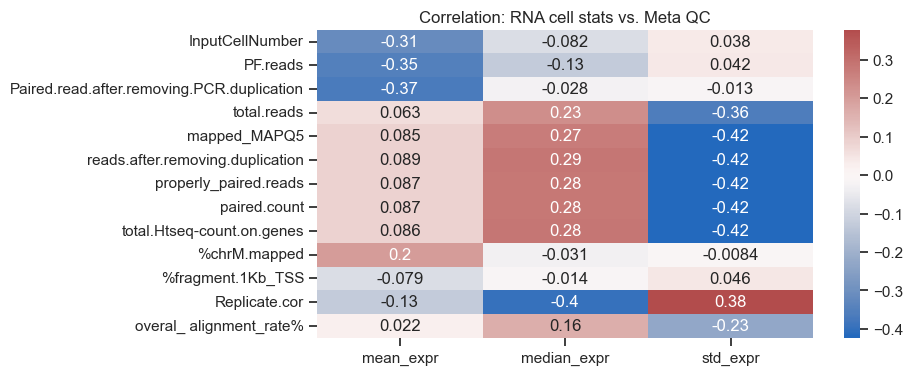

In [38]:
rna_correlation = pd.DataFrame(columns=rna_cell_stats.columns, index=meta_num.columns)
for col in rna_cell_stats.columns:
    for key in meta_num.columns:
        rna_correlation.loc[key, col] = rna_cell_stats[col].corr(meta[key], method='pearson') 

plt.figure(figsize=(8, 4))
sns.heatmap(rna_correlation.astype(float), annot=True, cmap="vlag", center=0)
plt.title("Correlation: RNA cell stats vs. Meta QC")
plt.show()